In [68]:
######################
##	Library Imports
######################
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.size']         = 22
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg import subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import njit, jit, prange
import scipy.stats
import itertools

mpl.get_backend()

'module://ipykernel.pylab.backend_inline'

In [69]:
def open_file(N, k0, a, beta, u0, iters, m_end, m_iter, trans, numLEs, func_type):
    
    HDFfileData = -1
    dof = int(N /2 - k0)
    
    ## Check if file exists and open
    if numLEs == 1:
        ## Create filename from data
        filename = input_dir + "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/LCEData_ITERS[{},{},{}]".format(N, k0, a, beta, u0, iters, m_end, m_iter)

        ## Check if file exists and open
        if os.path.exists(filename + "_TRANS[{}]_LEs[{}].h5".format(trans, numLEs)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]_LEs[{}].h5".format(trans, numLEs), 'r')
        elif os.path.exists(filename + "_TRANS[{}]_LEs[{}].h5".format(trans * 10, numLEs)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]_LEs[{}].h5".format(trans * 10, numLEs), 'r')
        elif os.path.exists(filename + "_TRANS[{}]_LEs[{}].h5".format(trans * 100, numLEs)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]_LEs[{}].h5".format(trans * 100, numLEs), 'r')
        elif os.path.exists(filename + "_TRANS[{}]_LEs[{}].h5".format(trans / 100, numLEs)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]_LEs[{}].h5".format(trans, numLEs), 'r')
        else: 
            print("File doesn't exist, check parameters!")
#             sys.exit()		
    else:
        ## Create filename from data
        filename = input_dir + "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/CLVData_ITERS[{},{},{}]".format(N, k0, a, beta, u0, iters, m_end, m_iter)

        if os.path.exists(filename + "_TRANS[{}].h5".format(trans)):
            HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans), 'r')
        elif os.path.exists(filename + "_TRANS[{}].h5".format(trans * 10)):
            HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans * 10), 'r')
        elif os.path.exists(filename + "_TRANS[{}].h5".format(trans / 10)):
            HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans / 10), 'r')
        elif os.path.exists(filename + "_TRANS[{}].h5".format(trans * 100)):
            HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans * 100), 'r')
        elif os.path.exists(filename + "_TRANS[{}]".format(trans) + "_LEs[{}].h5".format(dof)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]".format(trans) + "_LEs[{}].h5".format(dof), 'r')
        elif os.path.exists(filename + "_TRANS[{}]".format(trans * 10) + "_LEs[{}].h5".format(dof)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]".format(trans * 10) + "_LEs[{}].h5".format(dof), 'r')
        elif os.path.exists(filename + "_TRANS[{}]".format(trans / 10) + "_LEs[{}].h5".format(dof)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]".format(trans / 10) + "_LEs[{}].h5".format(dof), 'r')
        elif os.path.exists(filename + "_TRANS[{}]".format(trans * 100) + "_LEs[{}].h5".format(dof)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]".format(trans * 100) + "_LEs[{}].h5".format(dof), 'r')
        elif os.path.exists(filename + "_TRANS[{}]".format(trans * 1000) + "_LEs[{}].h5".format(dof)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]".format(trans * 1000) + "_LEs[{}].h5".format(dof), 'r')
        else: 
            print("File doesn't exist, check parameters!")
#             sys.exit()

    return HDFfileData

In [70]:
@njit
def compute_p_k(clv, a_k, num_tsteps, dof, numLEs):
    
    p_k            = np.zeros((num_tsteps, dof, dof))
    p_k_wnorm      = np.zeros((num_tsteps, dof, dof))

    K           = np.arange(2.0, float(dof + 2), 1.0)
    K_norm_sqr  = np.linalg.norm(K) ** 2
    K_wnorm_sqr = np.linalg.norm(K * a_k[2:]) ** 2
    
    for t in range(num_tsteps):
        
        for j in range(numLEs):
            # Project the vector to remove spatial translation invariance
            p_k[t, :, j]       = clv[t, :, j] - (K * (np.dot(clv[t, :, j], K))) / (K_norm_sqr)
            p_k_wnorm[t, :, j] = (clv[t, :, j] * a_k[2:]) - ((K * a_k[2:]) * (np.dot(clv[t, :, j] * a_k[2:], K * a_k[2:]))) / (K_wnorm_sqr)
            
            # Normalize
            p_k[t, :, j]       = np.square(p_k[t, :, j] / np.linalg.norm(p_k[t, :, j]))
            p_k_wnorm[t, :, j] = np.square(p_k_wnorm[t, :, j] / np.linalg.norm(p_k_wnorm[t, :, j]))

    return p_k, p_k_wnorm

In [71]:
N     = 1024
# alpha = np.arange(0.0, 3.5, 0.05)
alpha = np.array([1.0])

k0    = 1
beta  = 0.0
iters = 400000
m_end = 8000
m_itr = 50
trans = 0
u0    = "RANDOM"

input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/CLVs/CLV_Evolution"

/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/axes/_base.py:1398: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  'yscale=%s' % (xscale, yscale))
/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/axes/_base.py:1398: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  'yscale=%s' % (xscale, yscale))
/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/axes/_base.py:1398: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  'yscale=%s' % (xscale, yscale))


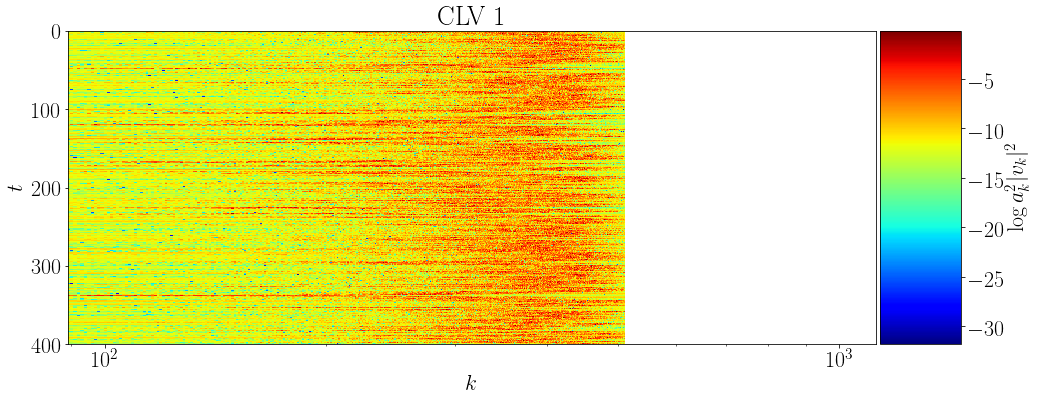

In [74]:
# for j, a in enumerate(alpha):
a = 1.00
## ------- Read in Data
HDFfileData = open_file(N, k0, a, beta, u0, iters, m_end, m_itr, 1000, int(N / 2 - k0), "max")
# if HDFfileData == -1:
#     continue

## ------ Output Dir
folder = "/N[{}]_ALPHA[{:0.3f}]".format(N, a)
if os.path.isdir(output_dir + folder) != True:
    os.mkdir(output_dir + folder)

## ------ Parameters
amps    = HDFfileData['Amps'][:]
kmin    = k0 + 1
num_osc = amps.shape[0]
dof     = num_osc - kmin

## ------ CLVs
CLVs          = HDFfileData['CLVs']
num_clv_steps = CLVs.shape[0]
clv_dims      = CLVs.attrs['CLV_Dims']
CLV           = np.reshape(CLVs, (CLVs.shape[0], dof, dof))

p_k, p_k_wnorm = compute_p_k(CLV, amps, num_clv_steps, dof, int(N / 2 - k0))

#         for j in range(dof):
j = 0
fig = plt.figure(figsize = (16, 16), tight_layout = False)
gs  = GridSpec(1, 1, hspace = 0.1 )

fig = plt.figure(figsize = (16, 16), tight_layout = False)
gs  = GridSpec(1, 1, hspace = 0.1 )

ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow( np.log(p_k_wnorm[:, :, j]), cmap = cm.jet)
# ax1.set_aspect('auto')
ax1.set_title(r"CLV {{{}}}".format(j + 1))
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$t$")
ax1.set_xscale('log')
div1  = make_axes_locatable(ax1)
cbax1 = div1.append_axes("right", size = "10%", pad = 0.05)
cb1   = plt.colorbar(im1, cax = cbax1)
cb1.set_label(r"$\log a_k^2 |v_k|^2 $")
plt.savefig(output_dir + folder + "/SpaceTime_k[{}].pdf".format(j + 1), bbox_inches='tight') 
plt.show()

        



/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


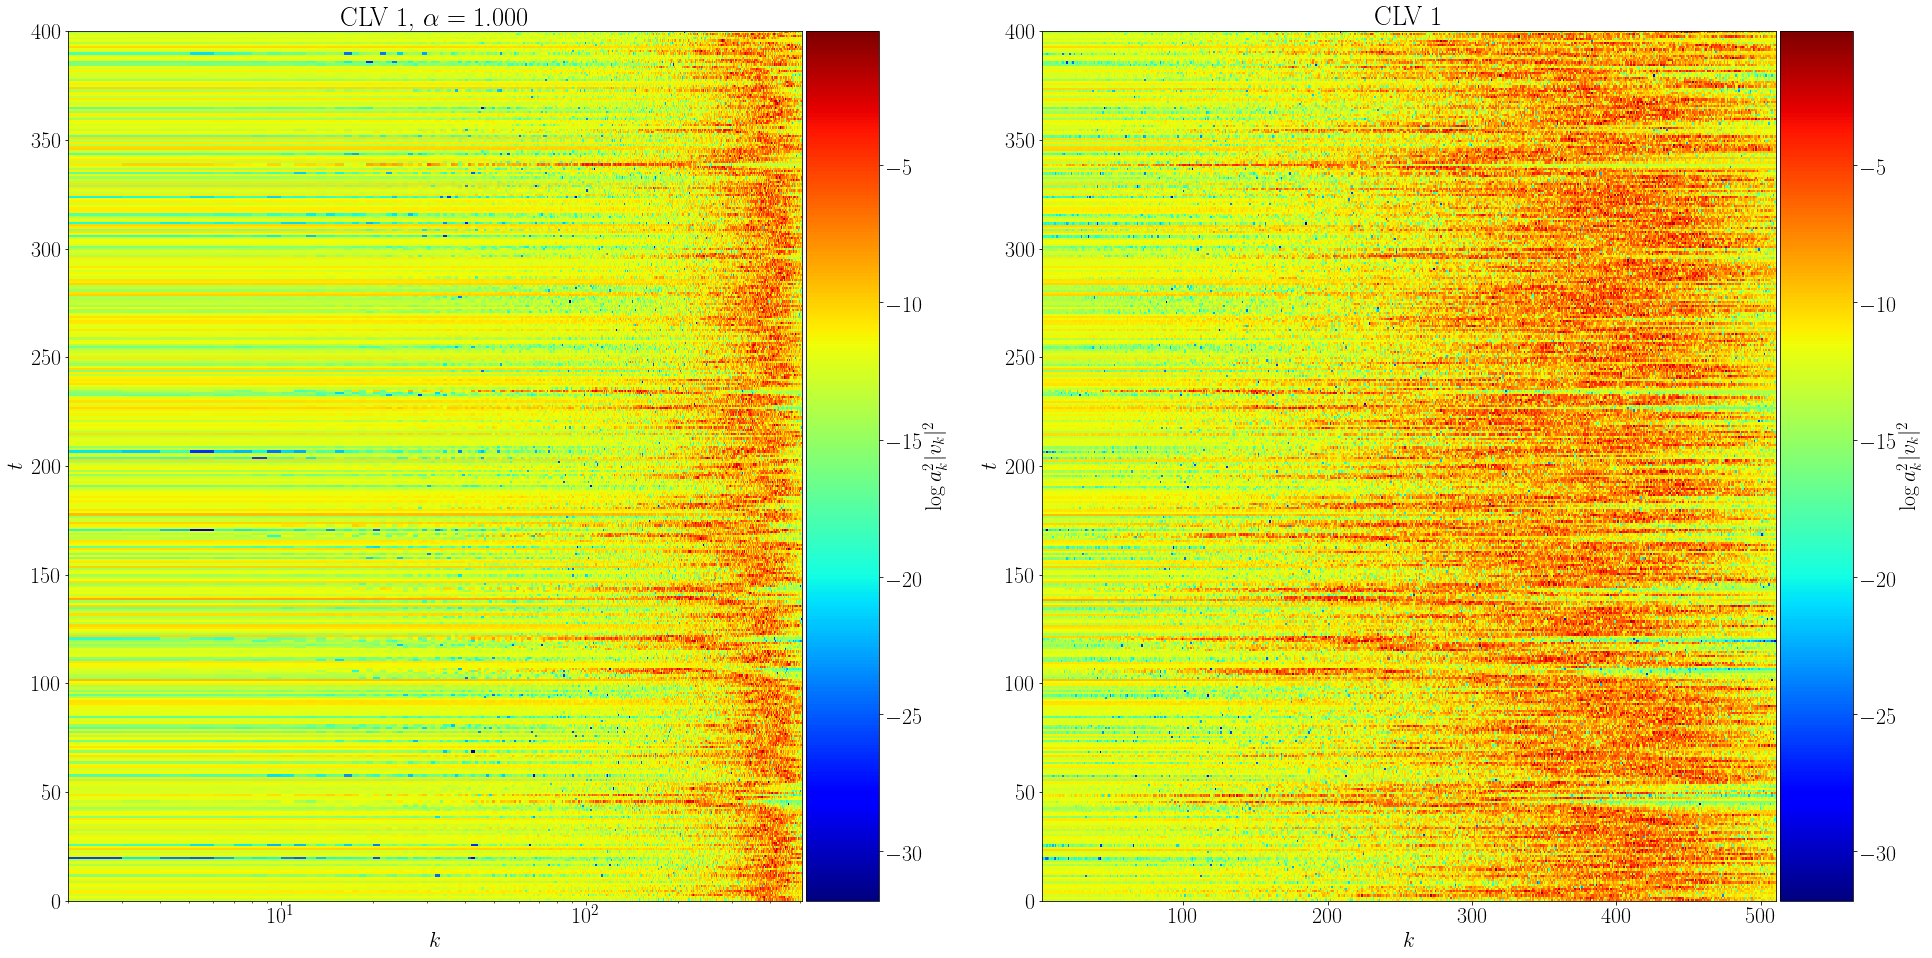

In [82]:
fig = plt.figure(figsize = (32, 16), tight_layout = True)
gs  = GridSpec(1, 2, hspace = 0.1 )

ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(np.flipud(np.log(p_k_wnorm[:, :, j])), cmap = cm.jet, extent = [kmin, dof, 0, num_clv_steps])
ax1.set_xscale('log')
ax1.set_aspect('auto')
ax1.set_title(r"CLV {{{}}}, $\alpha =$ {:0.3f}".format(j + 1, a))
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$t$")
div1  = make_axes_locatable(ax1)
cbax1 = div1.append_axes("right", size = "10%", pad = 0.05)
cb1   = plt.colorbar(im1, cax = cbax1)
cb1.set_label(r"$\log a_k^2 |v_k|^2 $")


ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(np.flipud(np.log(p_k_wnorm[:, :, j])), cmap = cm.jet, extent = [kmin, dof, 0, num_clv_steps])
ax2.set_aspect('auto')
ax2.set_title(r"CLV {{{}}}".format(j + 1))
ax2.set_xlabel(r"$k$")
ax2.set_ylabel(r"$t$")
div2  = make_axes_locatable(ax2)
cbax2 = div2.append_axes("right", size = "10%", pad = 0.05)
cb2   = plt.colorbar(im2, cax = cbax2)
cb2.set_label(r"$\log a_k^2 |v_k|^2 $")

# plt.savefig(output_dir + folder + "/SpaceTime_k[{}].pdf".format(j + 1), bbox_inches='tight') 
plt.show()
